## Droplet Matrix Filtering

In this notebook, we filtered the raw matrix to produce a cell matrix containing only those high quality barcodes \
github link: https://github.com/Ken-Lau-Lab/STAR_Protocol

In [1]:
# %env PYTHONHASHSEED=0
#import QCPipe #Contains functions required for the QC portion of this pipeline
import dropkick as dk #Contains dropkick functions
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [2]:
sc.set_figure_params(dpi=80) #Set figure size to 200 dpi for legibility
sc.settings.verbosity = 3 #Set scanpy verbosity to 3 for in depth function run information

In [3]:
import random
np.random.seed(56)
random.seed(56)

In [5]:
import glob

In [10]:
def reorder_AnnData(AnnData, descending = True):
    AnnData.obs['total_counts'] = AnnData.X.sum(axis=1)
    if(descending==True):
        AnnData = AnnData[np.argsort(AnnData.obs['total_counts'])[::-1]].copy()
        AnnData.uns['Order'] = 'Descending'
    elif(descending==False):
        AnnData = AnnData[np.argsort(AnnData.obs['total_counts'])[:]].copy()
        AnnData.uns['Order'] = 'Ascending'
    return(AnnData)

def read_dropest(dir_path,reorder=True):
    data_matrix = glob.glob(dir_path+"/*.mtx")[0]
    data_genes = glob.glob(dir_path+"/*features.*")[0]
    data_barcodes = glob.glob(dir_path+"/*barcodes.*")[0]
    adata = sc.read_mtx(data_matrix).T
    adata.var.index = pd.read_csv(data_genes,header=None,sep='\t')[0].values
    adata.obs.index = pd.read_csv(data_barcodes,header=None)[0].values
    adata.obs.index.name = 'Cells'
    adata.var.index.name = 'Genes'
    adata = reorder_AnnData(adata,descending=True)
    adata.raw = adata
    return(adata)

In [11]:
adata = read_dropest('8434-LG-1/cmraw_sparse')

In [12]:
adata.var_names_make_unique()

In [ ]:
## keep top10k cells
adata = adata[adata.obs.total_counts>141].copy()

In [21]:
adata

AnnData object with n_obs × n_vars = 10020 × 27843
    obs: 'total_counts'
    uns: 'Order'

In [22]:
dk.dropkick(adata)

filtered out 12 cells that have less than 50 genes expressed
filtered out 109 genes that are detected in less than 1 counts
Ignoring 12 barcodes with less than 50 genes detected
Ignoring 109 genes with zero total counts
Top 10 ambient genes have dropout rates between 2.888 and 9.343 percent:
	['MT-ND1', 'MT-RNR2', 'MT-ND4', 'MT-ATP6', 'MT-CO3', 'MT-CYB', 'RP5-857K21.4', 'MT-ND2', 'MT-CO1', 'LINC00486']
normalizing counts per cell
    finished (0:00:00)
Determining 2000 highly variable genes
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Setting arcsinh_norm layer to .X
Thresholding on heuristics for training labels:
	['arcsinh_n_genes_by_counts']

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


If you pass `n_top_genes`, all cutoffs are ignored.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00

[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   33.7s finished


LogitNet(alpha=0.1, max_iter=2000, n_jobs=2, n_splits=5, random_state=18,
         scoring='log_loss', standardize=False, verbose=True)

In [23]:
def reorder_AnnData(AnnData, descending = True):
    AnnData.obs['total_counts'] = AnnData.X.sum(axis=1)
    if(descending==True):
        AnnData = AnnData[np.argsort(AnnData.obs['total_counts'])[::-1]].copy()
        AnnData.uns['Order'] = 'Descending'
    elif(descending==False):
        AnnData = AnnData[np.argsort(AnnData.obs['total_counts'])[:]].copy()
        AnnData.uns['Order'] = 'Ascending'
    return(AnnData)

In [24]:
def find_inflection(adata_in,mito_tag = "mt-",run_qc=True):
    if(run_qc):
        print("Calculating QC Metrics")
        adata_in.var['Mitochondrial'] = adata_in.var.index.str.startswith(mito_tag)
        sc.pp.calculate_qc_metrics(adata_in,qc_vars=['Mitochondrial'],use_raw=True,inplace=True)
    tc_ngbc_ratio = adata_in.obs['total_counts']/adata_in.obs['n_genes_by_counts']
    data_cumsum = np.cumsum(adata_in.obs['total_counts'])
    x_vals=np.arange(0,adata_in.n_obs)
    secant_coef=data_cumsum[adata_in.obs.shape[0]-1]/adata_in.obs.shape[0]
    secant_line=secant_coef*x_vals
    secant_dist=abs(data_cumsum-secant_line)
    inflection_points = secant_dist.argsort()[::-1]
    inflection_percentiles = [0,15,30]
    inflection_percentiles_inds = np.percentile(x_vals[x_vals>inflection_points[0]],inflection_percentiles).astype(int)
    color=plt.cm.tab10(np.linspace(0,1,adata_in.n_obs))

    fig = plt.figure( figsize=(20,6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.plot(np.array(data_cumsum), label="Cumulative Sum")
    ax1.plot(np.array(secant_dist), label="Secant Distance")
    for percentile in inflection_percentiles_inds:
        ax1.axvline(x=percentile,ymin=0,c=color[percentile],linestyle='--',linewidth=2,label="Inflection point {}".format(percentile))
    ax1.legend()
    ax1.set_xlabel("Cell Rank")
    ax1.set_ylabel("Total Counts per Cell")
    ax1.set_title('Inflection Curve')
        
    ax2.plot(np.sort(tc_ngbc_ratio.values)[::-1],label='Total Counts/N Genes By Counts')
    #ax2.plot(np.sort(adata_in.obs['pct_counts_Mitochondrial'])[::-1]/100)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_title('Total Counts/N Genes By Counts')
    ax2.set_xlabel("Cell Rank")
    ax2.set_ylabel("Total Counts/N Genes By Counts")
    ax2.legend()
        
    print("Inflection point at {} for {} percentiles of greatest secant distances".format(inflection_percentiles_inds,inflection_percentiles))
    return(inflection_percentiles_inds)

In [25]:
adata = reorder_AnnData(adata)

Calculating QC Metrics


OMP: Info #274: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Inflection point at [2067 3259 4452] for [0, 15, 30] percentiles of greatest secant distances


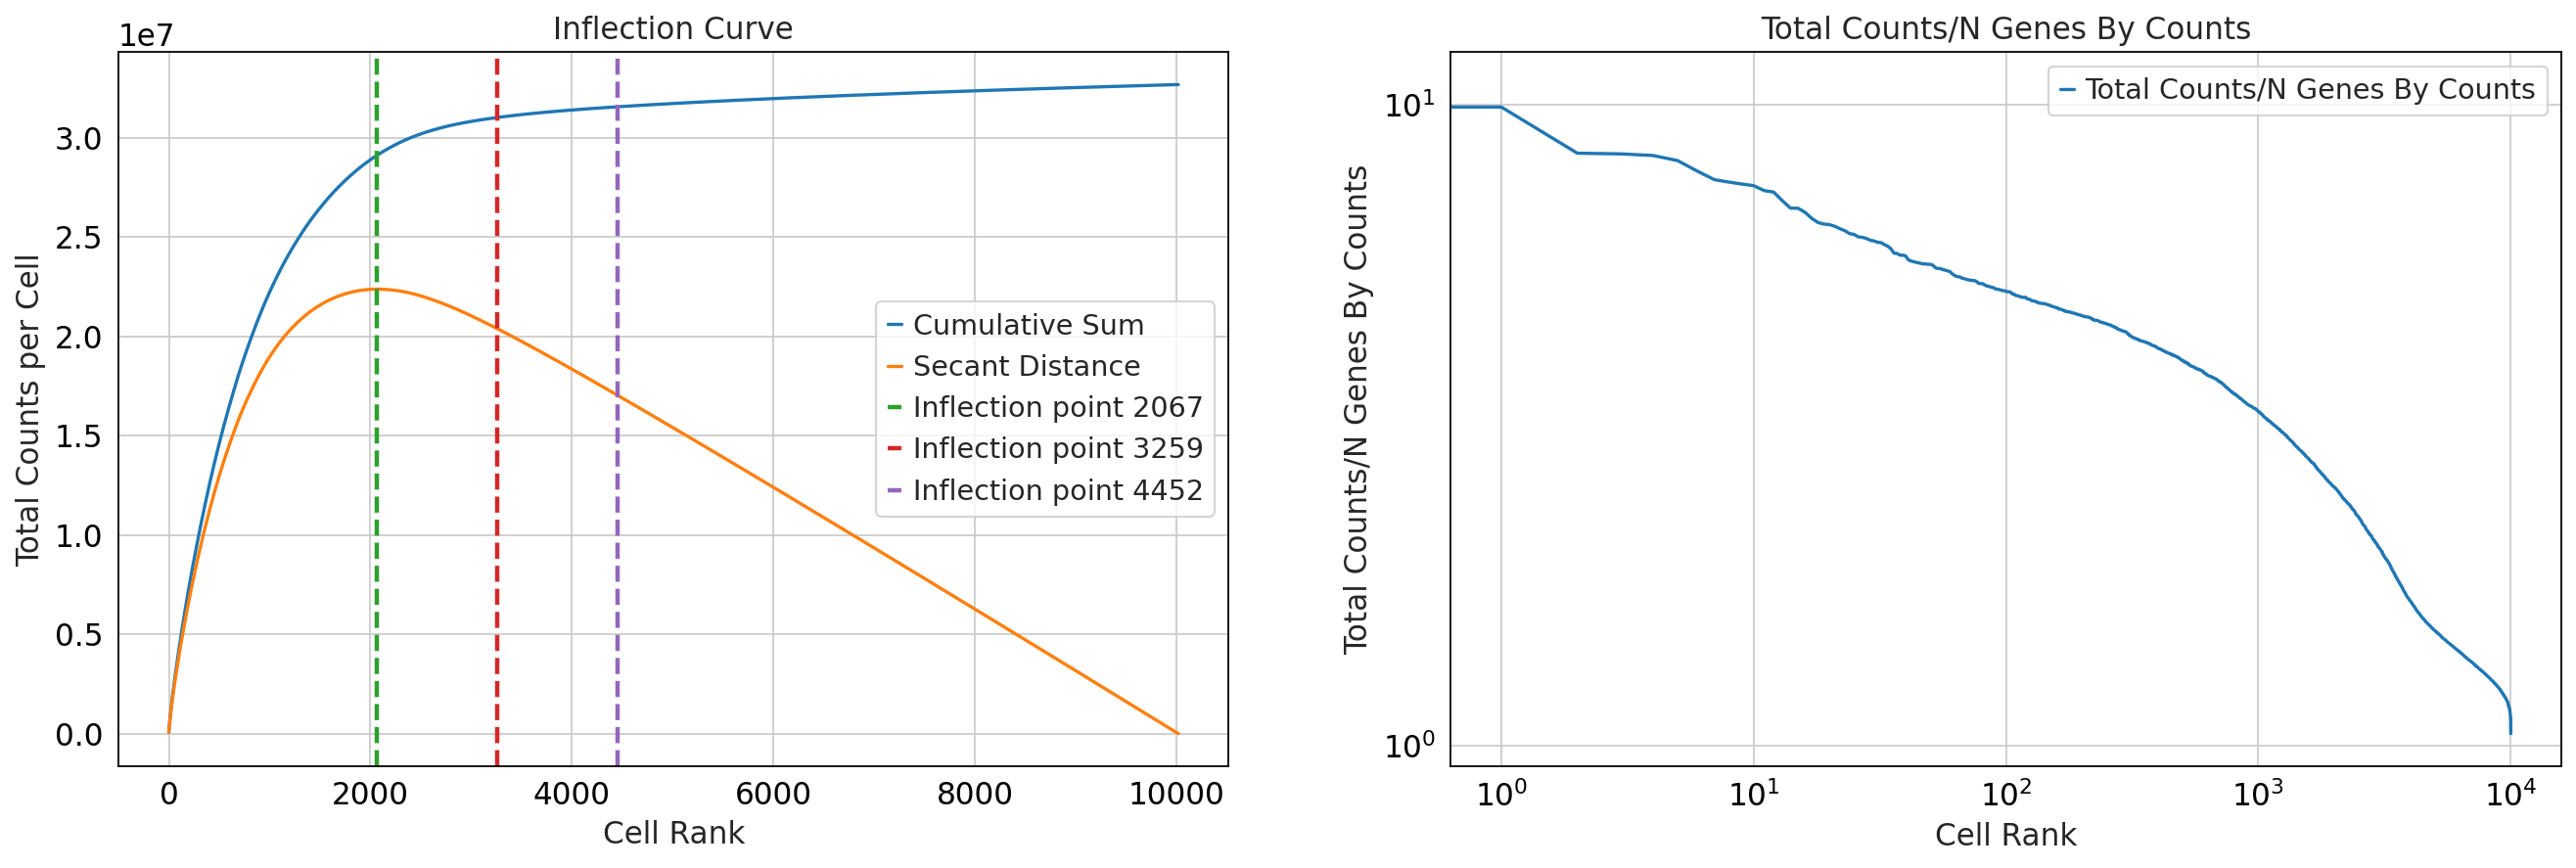

In [26]:
inf =find_inflection(adata)

In [27]:
adata[inf[0]].obs.total_counts[0]

3262.0

In [28]:
sc.pp.filter_cells(adata,min_counts=adata[inf[0]].obs.total_counts[0])

filtered out 7952 cells that have less than 3262.0 counts


In [29]:
adata

AnnData object with n_obs × n_vars = 2068 × 27843
    obs: 'total_counts', 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_Mitochondrial', 'log1p_total_counts_Mitochondrial', 'pct_counts_Mitochondrial', 'n_counts'
    var: 'dropkick_coef', 'Mitochondrial', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'Order', 'dropkick_thresholds', 'dropkick_args'

In [30]:
adata.obs['dropkick_label'].value_counts()

True     1744
False     324
Name: dropkick_label, dtype: int64

In [ ]:
# keep cells with dropkick score > 0.5
data_out = adata[adata.obs['dropkick_score']>0.5]

In [33]:
data_out_new = sc.AnnData(data_out.to_df())
data_out_new.obs['dropkick_score'] = data_out.obs['dropkick_score']

In [34]:
data_out_new

AnnData object with n_obs × n_vars = 1744 × 27843
    obs: 'dropkick_score'

In [ ]:
data_out_new.write_h5ad('8434-1-filtered.h5ad',compression='gzip')